In [3]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt


import hj_reachability as hj
from aa598.hw3_helper import plot_value_function


In [4]:
class RelativeDynamicUnicycle(hj.ControlAndDisturbanceAffineDynamics):

    def __init__(self,
                 ego_min_acceleration=-.5,
                 ego_max_acceleration=.5,
                 contender_min_acceleration=-.5,
                 contender_max_acceleration=.5,
                 ego_angular_rate_limit=.3,
                 contender_angular_rate_limit=.3,
                 ego_min_speed=0.,
                 ego_max_speed=2.,
                 contender_min_speed=0.,
                 contender_max_speed=2.,
                 control_mode="max",
                 disturbance_mode="min",
                 control_space=None,
                 disturbance_space=None):
        
        self.ego_min_max_speed = [ego_min_speed, ego_max_speed]
        self.contender_min_max_speed = [contender_min_speed, contender_max_speed]

        if control_space is None:
            control_space = hj.sets.Box(jnp.array([-ego_angular_rate_limit, ego_min_acceleration]),
                                        jnp.array([ego_angular_rate_limit, ego_max_acceleration]))
        if disturbance_space is None:
            disturbance_space = hj.sets.Box(jnp.array([-contender_angular_rate_limit, contender_min_acceleration]),
                                            jnp.array([contender_angular_rate_limit, contender_max_acceleration]))     
               
        super().__init__(control_mode, disturbance_mode, control_space, disturbance_space)


    def open_loop_dynamics(self, state, time):
        xR, yR, thetaR, vA, vB = state
        # limit speed
        vA = jnp.clip(vA, *self.ego_min_max_speed)
        vB = jnp.clip(vB, *self.contender_min_max_speed)
        # TODO: WRITE YOUR CODE HERE
        
        return jnp.array([
            -vA + vB * jnp.cos(thetaR),
            vB * jnp.sin(thetaR), 
            0.,
            0.,
            0.,
        ])

    def control_jacobian(self, state, time):
        # TODO: WRITE YOUR CODE HERE
        xR, yR, thetaR, vA, vB = state

        return jnp.array([
            [yR, 0], 
            [-xR, 0],
            [-1., 0.], 
            [0., 1.],
            [0., 0.]
        ])
    
    def disturbance_jacobian(self, state, time):
        # TODO: WRITE YOUR CODE HERE
        xR, yR, thetaR, vA, vB = state

        return jnp.array([
            [0., 0.], 
            [0., 0.],
            [1., 0.], 
            [0., 0.], 
            [0., 1.]
        ])


In [5]:
# adjust the grid size as necessary depending on your available compute. 
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(lo=np.array([-10., -10., -np.pi, -1., -1.]),
                                                                           hi=np.array([10., 10., np.pi, 3., 3.])),
                                                               (21, 21, 10, 15, 15),
                                                               periodic_dims=2)
# initial value function
r_col = 0.5
init_values = jnp.linalg.norm(grid.states[..., :2], axis=-1) - r_col

# solver settings, can change accuracy to "low", "high" or "very_high". 
# set postprocessor ro backward_reachable_tube
solver_settings = hj.SolverSettings.with_accuracy("medium", hamiltonian_postprocessor=hj.solver.backwards_reachable_tube)

# set time horizon. negative because we are computing backward in time. If target_time > 0, then you will compute the forwrd reachable set
time = 0.
target_time = -5.0

In [ ]:
# using default values for the dynamics
dynamics = RelativeDynamicUnicycle()

# solve for the BRT!
target_values = hj.step(solver_settings, dynamics, grid, time, init_values, target_time)

100%|##########|  5.0000/5.0 [00:41<00:00,  8.24s/sim_s]


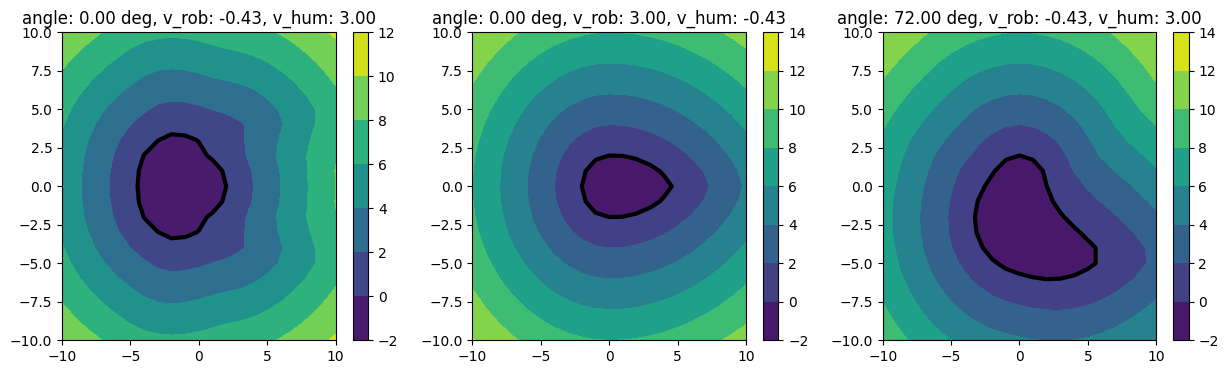

In [61]:
# plot three figures at different slices of the BRT
plt.figure(figsize=(15, 4))

plt.subplot(1,3,1)
# human faster than robot
plot_value_function(5, 2, 14, target_values, grid)

plt.subplot(1,3,2)
# robot faster than human
plot_value_function(5, 14, 2, target_values, grid)

plt.subplot(1,3,3)

plot_value_function(7, 2, 14, target_values, grid)

In [60]:
# TODO: set values according to your assumption on agnet behavior
ego_min_acceleration = -2
ego_max_acceleration = 2
contender_min_acceleration = -1
contender_max_acceleration = 1
ego_angular_rate_limit = 0.5
contender_angular_rate_limit = 1.0
ego_min_speed = 0
ego_max_speed = 5
contender_min_speed = 0
contender_max_speed = 5
control_mode = "max"
disturbance_mode = "min"

dynamics = RelativeDynamicUnicycle(
                                    ego_min_acceleration=ego_min_acceleration,
                                    ego_max_acceleration=ego_max_acceleration,
                                    contender_min_acceleration=contender_min_acceleration,
                                    contender_max_acceleration=contender_max_acceleration,
                                    ego_angular_rate_limit=ego_angular_rate_limit,
                                    contender_angular_rate_limit=contender_angular_rate_limit,
                                    ego_min_speed=ego_min_speed,
                                    ego_max_speed=ego_max_speed,
                                    contender_min_speed=contender_min_speed,
                                    contender_max_speed=contender_max_speed,
                                    control_mode=control_mode,
                                    disturbance_mode=disturbance_mode
                                    )

target_values = hj.step(solver_settings, dynamics, grid, time, init_values, target_time)

100%|##########|  5.0000/5.0 [01:20<00:00, 16.19s/sim_s]
